# What drives the price of a car?

![](images/kurt.jpeg)

# Business Understanding
The purpose of this project is analyzing ~400,000 car sales records throughout the country and identifying the driver for used car prices. This way, we help used car dealers to adjust their inventories for the cars that sell for the highest price. As part of the analysis we also provide volume of best selling used car categories, which can be used as a metric to maximize suppy to their inventories and increase sales volumes.

# Data Understanding

We go through the following steps to understand the data:
- Describe the data
- Explore the data for price distribution
- Explore correlations between price and various variables
- Check data quality and identify issues
- Come up with a strategy to remediate data quality issues


In [210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [211]:
car_orig = pd.read_csv('data/vehicles.csv')
car_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [212]:
car_orig.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


Text(0.5, 1.0, 'price distribution')

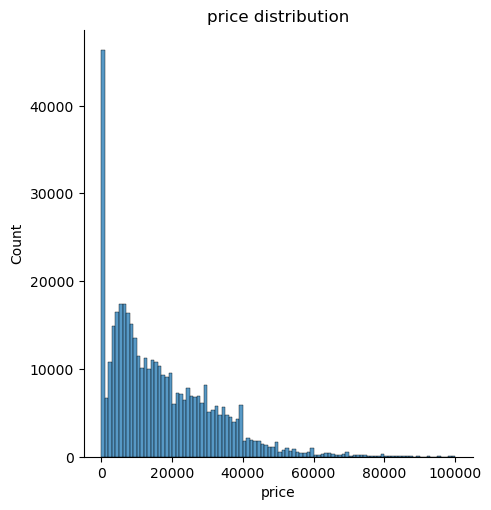

In [251]:
data = car_orig[car_orig['price']<100000]
sns.displot(data, x='price', bins=100)
plt.title('price distribution')
#data needs to be clearned up for zero price and the talk beyond a certain max value

#### Data Preperation Plan
- Limit the price between \\$2k and \\$60k to eliminate outliers
- Drop following columns:
    - id -> no statistical value
    - VIN -> no statistical value
    - region -> already captured in state
    - size -> most of the values are missing
- Convert year to age assuming the data collection date of 2022
- Eliminate null values and pick one of the strategies based on the nature of the data
    - If large number of null values: Eliminate the column
    - If small number of null values: Assign the most common data for categorical or mean for numerical.

In order to conduct further data exploration, we will need some data preparation. Data understanding and Data preparation are typically iterative steps in CRISP-DM.

### Data Preparation

We prepare the data according to the data preperation plan we came up with in the previous step. As part of this step, we also further explore the data.

In [252]:
#limit data to $2000 - $60000
car_clean =  car_orig[(car_orig['price']>2000) & (car_orig['price']<60000)]

#drop columns that doesn't add value
car_clean = car_clean.drop(columns=['id', 'VIN', 'region', 'size'])

In [253]:
#assign mean to missing year. convert year -> age
mean_year = int(car_clean['year'].mean())
print(mean_year)
car_clean['year'] = car_clean['year'].fillna(mean_year)

car_clean['age'] = 2022 - car_clean['year']
car_clean.drop(columns=['year'], axis=0)


2011


,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,age
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,11.0
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,11.0
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,11.0
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,11.0
7,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,NaN,wy,3.0
426876,30590,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,fwd,sedan,red,wy,2.0
426877,34990,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,NaN,hatchback,white,wy,2.0
426878,28990,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,4.0


In [254]:
#manufacturer and model - drop null values as it is rare
car_clean = car_clean.dropna(subset=['manufacturer', 'model'])

In [255]:
#condition - assign most common to missing values
car_clean['condition'] = car_clean['condition'].fillna('good')
car_clean['condition'].value_counts()

good         240161
excellent     86030
like new      17559
fair           3650
new             771
salvage         233
Name: condition, dtype: int64

In [256]:
#cylinders - assign most common value to null
car_clean['cylinders'] = car_clean['cylinders'].fillna('6 cylinders')
car_clean['cylinders'].value_counts()

6 cylinders     221234
4 cylinders      64770
8 cylinders      58672
5 cylinders       1413
10 cylinders      1050
other              720
3 cylinders        461
12 cylinders        84
Name: cylinders, dtype: int64

In [257]:
#fuel - assign most common value to null
car_clean['fuel'] = car_clean['fuel'].fillna('gas')
car_clean['fuel'].value_counts()

gas         297756
other        25349
diesel       19259
hybrid        4603
electric      1437
Name: fuel, dtype: int64

In [258]:
#odometer - assign mean value to missisng odometer
car_clean['odometer'] = car_clean['odometer'].fillna(mean_odometer)
car_clean['odometer'].value_counts()

95669.692207     1898
1.000000         1250
150000.000000    1163
200000.000000    1129
100000.000000    1052
                 ... 
56457.000000        1
149119.000000       1
78546.000000        1
135090.000000       1
69550.000000        1
Name: odometer, Length: 91659, dtype: int64

In [259]:
#title_status - assign most common value to missing
car_clean['title_status'] = car_clean['title_status'].fillna('clean')
car_clean['title_status'].value_counts()

clean         337053
rebuilt         6557
salvage         3201
lien            1237
missing          307
parts only        49
Name: title_status, dtype: int64

In [260]:
#transmission - assign most common to missing
car_clean['transmission'] = car_clean['transmission'].fillna('automatic')
car_clean['transmission'].value_counts()

automatic    271557
other         58295
manual        18552
Name: transmission, dtype: int64

In [261]:
#drive - assign most common to missing
car_clean['drive'] = car_clean['drive'].fillna('4wd')
car_clean['drive'].value_counts()

4wd    212000
fwd     88719
rwd     47685
Name: drive, dtype: int64

In [262]:
#type - assign most common to missing
car_clean['type'] = car_clean['type'].fillna('sedan')
car_clean['type'].value_counts()

sedan          143775
SUV             64830
pickup          38304
truck           25798
other           18243
coupe           15565
hatchback       14148
wagon            9386
van              7203
convertible      6316
mini-van         4061
offroad           511
bus               264
Name: type, dtype: int64

In [263]:
#paint color = assign 'unkown' to missing values.
car_clean['paint_color'] = car_clean['paint_color'].fillna('unknown')
car_clean['paint_color'].value_counts()

unknown    98091
white      65217
black      54009
silver     37102
blue       26732
red        25681
grey       20745
green       5816
custom      5688
brown       5605
orange      1608
yellow      1572
purple       538
Name: paint_color, dtype: int64

In [264]:
car_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348404 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         348404 non-null  int64  
 1   year          348404 non-null  float64
 2   manufacturer  348404 non-null  object 
 3   model         348404 non-null  object 
 4   condition     348404 non-null  object 
 5   cylinders     348404 non-null  object 
 6   fuel          348404 non-null  object 
 7   odometer      348404 non-null  float64
 8   title_status  348404 non-null  object 
 9   transmission  348404 non-null  object 
 10  drive         348404 non-null  object 
 11  type          348404 non-null  object 
 12  paint_color   348404 non-null  object 
 13  state         348404 non-null  object 
 14  age           348404 non-null  float64
dtypes: float64(3), int64(1), object(11)
memory usage: 42.5+ MB


Now the data has no null values, we can transform columns to numerical values to explore correlations and prepare for regression. 

In [265]:
#transform categorical variables to numeric
ordinal_transformer = make_column_transformer(
        (OrdinalEncoder(categories = [['0', '1', '2', '3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '7', '8 cylinders', '9', '10 cylinders', '11', '12 cylinders', 'other']]), ['cylinders']),
        (OrdinalEncoder(categories = [['new', 'like new', 'excellent', 'good', 'fair', 'salvage']]), ['condition']),
        (OrdinalEncoder(), ['manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']),
        ('passthrough', ['odometer']),
        ('passthrough', ['age']),
        ('passthrough', ['price'])
)

car_numeric = pd.DataFrame()
car_numeric[['cylinders', 'condition', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'odometer', 'age', 'price']] = ordinal_transformer.fit_transform(car_clean)
car_numeric

,cylinders,condition,manufacturer,model,fuel,title_status,transmission,drive,type,paint_color,state,odometer,age,price
0,8.0,3.0,14.0,16525.0,2.0,0.0,2.0,0.0,8.0,11.0,1.0,57923.0,8.0,33590.0
1,8.0,3.0,7.0,16841.0,2.0,0.0,2.0,0.0,8.0,1.0,1.0,71229.0,12.0,22590.0
2,8.0,3.0,7.0,16885.0,2.0,0.0,2.0,0.0,8.0,8.0,1.0,19160.0,2.0,39590.0
3,8.0,3.0,38.0,19461.0,2.0,0.0,2.0,0.0,8.0,8.0,1.0,41124.0,5.0,30990.0
4,6.0,2.0,13.0,8438.0,2.0,0.0,0.0,2.0,10.0,0.0,1.0,128000.0,9.0,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348399,6.0,3.0,30.0,12730.0,2.0,0.0,2.0,1.0,9.0,10.0,50.0,32226.0,3.0,23590.0
348400,6.0,3.0,40.0,15941.0,2.0,0.0,2.0,1.0,9.0,8.0,50.0,12029.0,2.0,30590.0
348401,6.0,3.0,6.0,20687.0,0.0,0.0,2.0,0.0,4.0,11.0,50.0,4174.0,2.0,34990.0
348402,6.0,3.0,23.0,7562.0,2.0,0.0,2.0,1.0,9.0,9.0,50.0,30112.0,4.0,28990.0


Text(0.5, 1.0, 'price distribution')

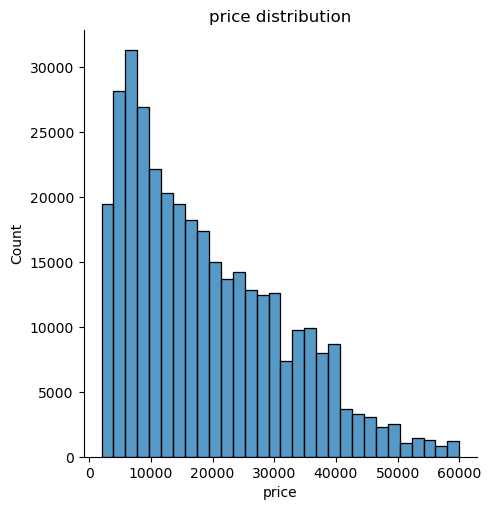

In [267]:
sns.displot(car_numeric, x='price', bins=30)
plt.title('price distribution')
#data is left skewed. sqrt of price can be considered to approximate normal distribution

Text(0.5, 1.0, 'price sqrt distribution')

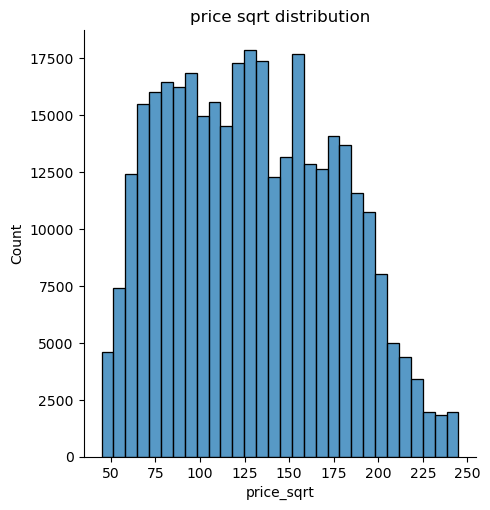

In [268]:
car_numeric['price_sqrt'] = np.sqrt(car_numeric['price'])
sns.displot(car_numeric, x='price_sqrt', bins=30)
plt.title('price sqrt distribution')

Text(0.5, 1.0, 'correlation of variables')

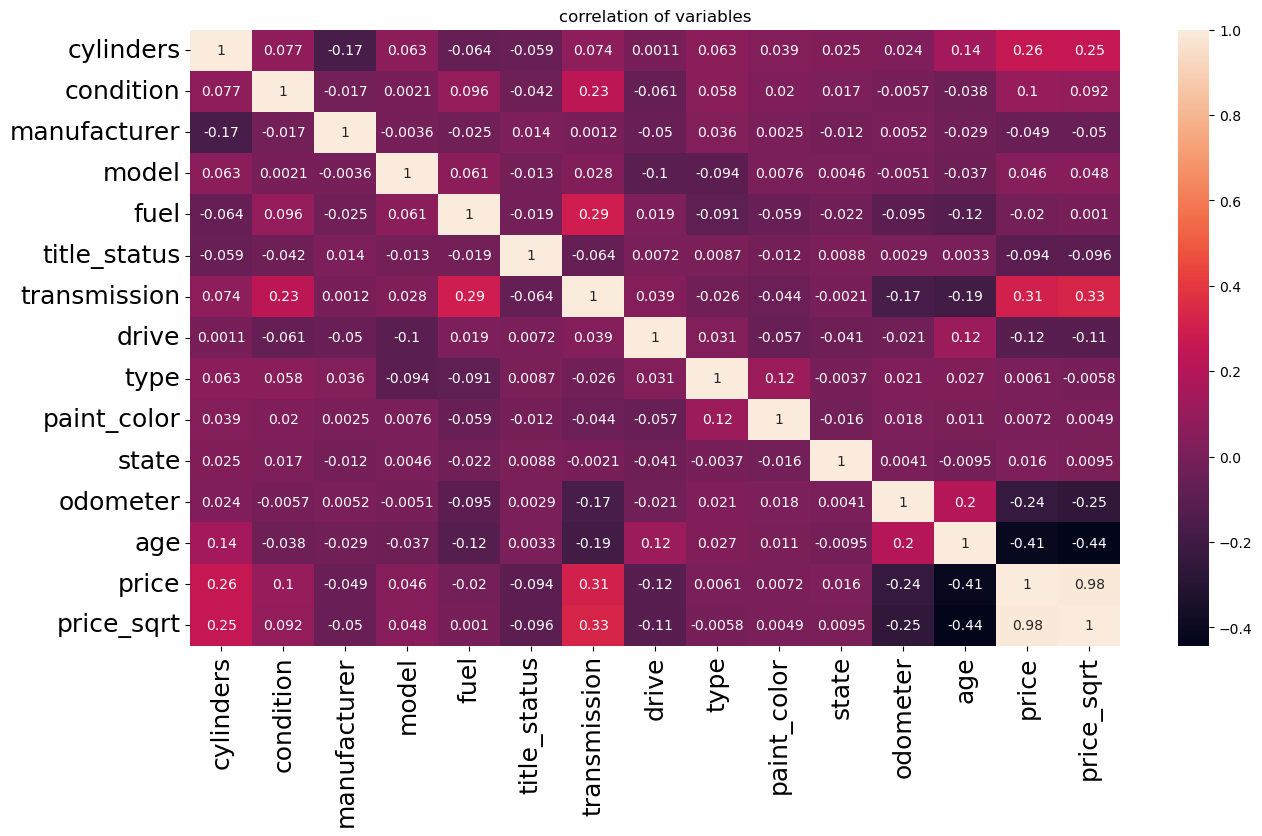

In [269]:
plt.figure(figsize=(15,8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
sns.heatmap(car_numeric.corr(), annot=True)
plt.title('correlation of variables')
#age, odometer and cylinders has the most correlation with price

Text(0.5, 1.0, 'car age vs. price')

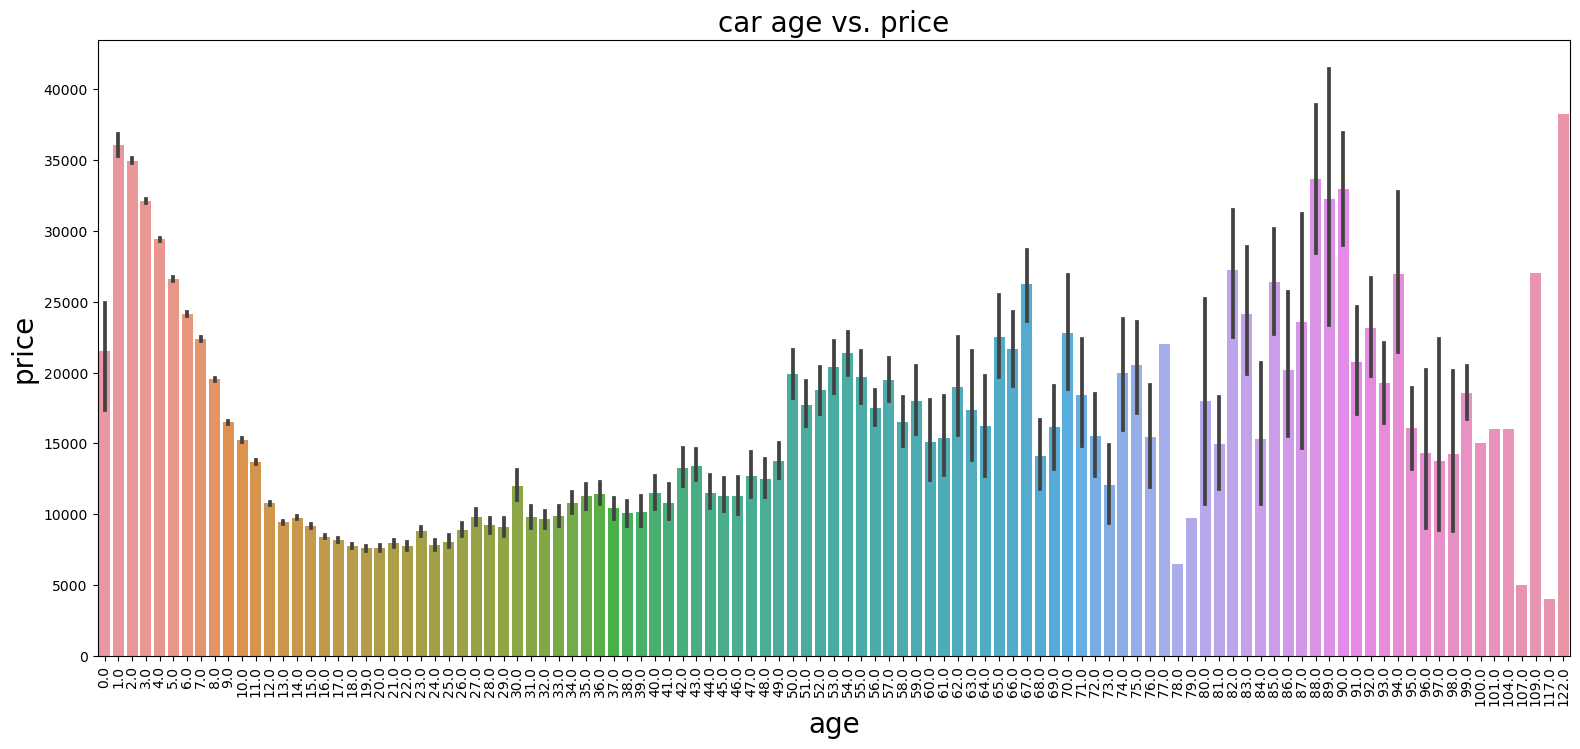

In [271]:
plt.figure(figsize=(19,8))
plt.xlabel('cylinders', fontsize=20)
plt.ylabel('price', fontsize=20)
plt.xticks(rotation=90)
sns.barplot(car_clean, x='age', y='price')
plt.title('car age vs. price', fontsize=20)

#car price drops quickly with age, stabilizes and then incrases as they become classics/vintage

Text(0.5, 1.0, 'cylinders vs. price')

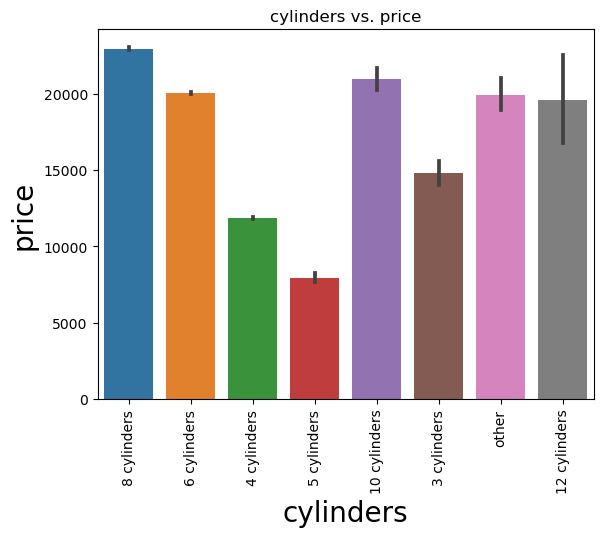

In [272]:
plt.xlabel('cylinders', fontsize=20)
plt.ylabel('price', fontsize=20)
plt.xticks(rotation=90)
sns.barplot(car_clean, x='cylinders', y='price')
plt.title('cylinders vs. price')

#Number of cylinders definitely drive price

Text(0.5, 1.0, 'odometer miles vs. price')

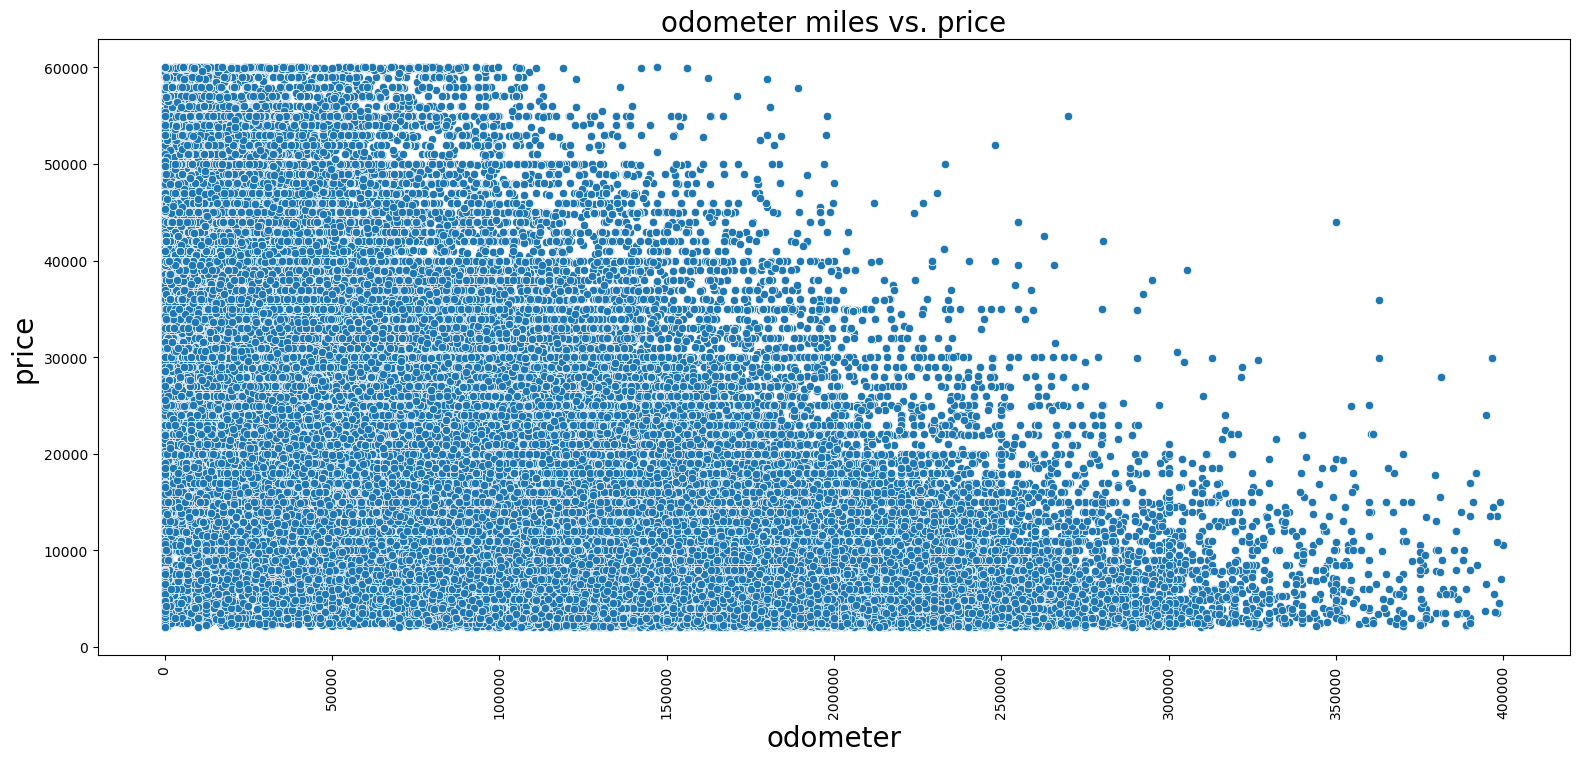

In [274]:
plt.figure(figsize=(19,8))
plt.xticks(rotation=90)
plt.xlabel('odometer', fontsize=20)
plt.ylabel('price', fontsize=20)
sns.scatterplot(car_clean[car_clean['odometer']<400000], x='odometer', y='price')
plt.title('odometer miles vs. price', fontsize=20)

#price decline with increase miles on odometer

Text(0.5, 1.0, 'condition vs. price')

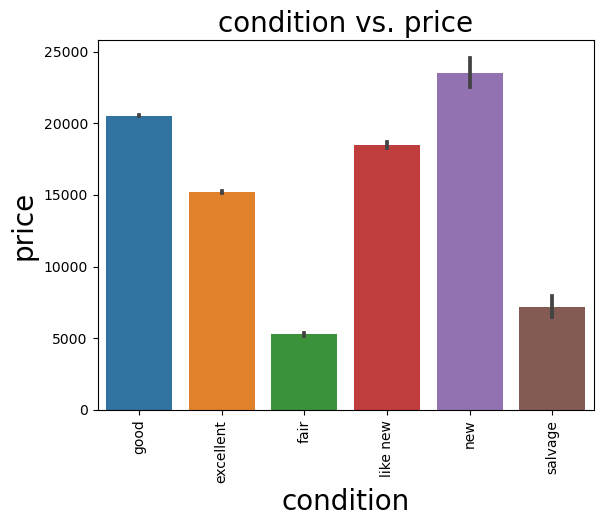

In [275]:
plt.xticks(rotation=90)
plt.xlabel('condition', fontsize=20)
plt.ylabel('price', fontsize=20)
sns.barplot(car_clean, x='condition', y='price')
plt.title('condition vs. price', fontsize=20)

#new, like new and good goes for the best price

Text(0.5, 1.0, 'title status vs. price')

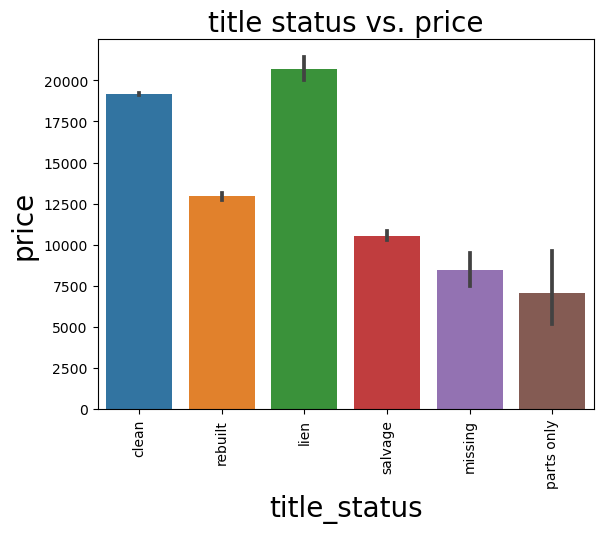

In [276]:
plt.xticks(rotation=90)
plt.xlabel('title status', fontsize=20)
plt.ylabel('price', fontsize=20)
sns.barplot(car_clean, x='title_status', y='price')
plt.title('title status vs. price', fontsize=20)

#clean cars go for higher price than rebuilt, salvage, missing, etc.

Text(0.5, 1.0, 'transmission vs. price')

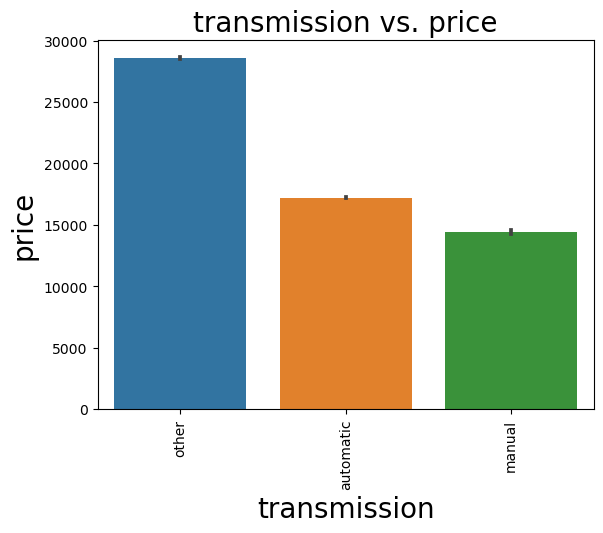

In [277]:
plt.xticks(rotation=90)
plt.xlabel('title status', fontsize=20)
plt.ylabel('price', fontsize=20)
sns.barplot(car_clean, x='transmission', y='price')
plt.title('transmission vs. price', fontsize=20)

#automatic is higher than manual

Text(0.5, 1.0, 'drive vs. price')

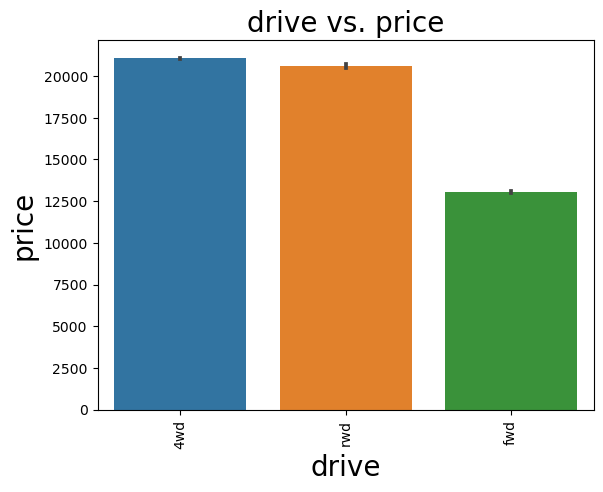

In [278]:
plt.xticks(rotation=90)
plt.xlabel('title status', fontsize=20)
plt.ylabel('price', fontsize=20)
sns.barplot(car_clean, x='drive', y='price')
plt.title('drive vs. price', fontsize=20)

#4wd > rwd > fwd

Text(0.5, 1.0, 'fuel miles vs. price')

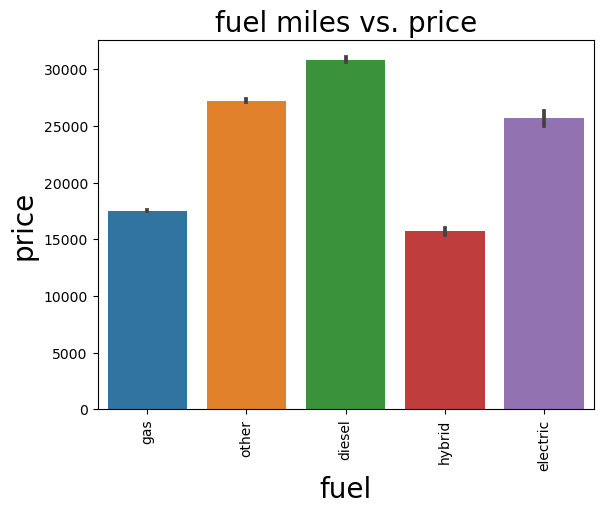

In [279]:
plt.xticks(rotation=90)
plt.xlabel('title status', fontsize=20)
plt.ylabel('price', fontsize=20)
sns.barplot(car_clean, x='fuel', y='price')
plt.title('fuel miles vs. price', fontsize=20)

#diesel > gas

### Modeling

We will be building 3 types models, using 3 different sets of variables:
- Model 1: LinearRegression
- Model 2: Grid search on Ridge using 100 different alphas and picking the best
- Model 2: Grid search on Lasso using 100 different alphas and picking the best

Scaled data will be fed to each model to give fair chance to each variable as we adjust the hyperparameter.

Each model will be repeated with 3 variable sets:
- Set 1: Most statistically important columns -> ['age', 'odometer', 'cylinders']
- Set 2: Majority of the columns -> ['age', 'odometer', 'cylinders', 'condition', 'manufacturer', 'model', 'fuel', 'transmission', 'drive']
- Set 3: Most statistically important 6 colimns ['age', 'odometer', 'cylinders', 'fuel', 'transmission', 'drive']

Training MSE and Test MSE will be computed for each. Results of these models will be compared for performance to pick the best model.

In [193]:
def generate_results(data, input_columns, output_column, findings):

    X = data[input_columns]
    y = data[output_column]
    
    #Standard Scaler
    print('running StandardScaler...')
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    
    #Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    #Linear Regression
    print('running LinearRegression...')
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    training_mse = mean_squared_error(lin_reg.predict(X_train), y_train)
    test_mse = mean_squared_error(lin_reg.predict(X_test), y_test)
    findings.loc[len(findings.index)] = ['LinearRegression', None, len(input_columns), training_mse, test_mse, lin_reg.coef_]


    #Parameters for alpha grid search
    parameters_to_try = {'alpha':10**np.linspace(-5,4,100)}
    
    #Ridge Regression Grid Search to find best alpha
    print('running GridSearch on RidgeRegression...')
    gs = GridSearchCV(Ridge(), parameters_to_try, scoring='neg_mean_squared_error')
    gs.fit(X_train, y_train)

    estimator = gs.best_estimator_

    training_mse = mean_squared_error(estimator.predict(X_train), y_train)
    test_mse = mean_squared_error(estimator.predict(X_test), y_test)

    findings.loc[len(findings.index)] = ['RidgeRegression', gs.best_params_, len(input_columns), training_mse, test_mse, estimator.coef_]


    #Lasso Regression Grid Search to find best alpha
    print('running GridSearch on LassoRegression...')
    gs = GridSearchCV(Lasso(), parameters_to_try, scoring='neg_mean_squared_error')
    gs.fit(X_train, y_train)

    estimator = gs.best_estimator_

    training_mse = mean_squared_error(estimator.predict(X_train), y_train)
    test_mse = mean_squared_error(estimator.predict(X_test), y_test)

    findings.loc[len(findings.index)] = ['LassoRegression', gs.best_params_, len(input_columns), training_mse, test_mse, estimator.coef_]

    return findings

In [194]:
#prepare empty dataframe to keep findings
findings = pd.DataFrame(columns=['Model', 'Alpha', 'Columns Used', 'Training MSE', 'Test MSE', 'Coefficients'])

#most relevant 3 columns
input_columns = ['age', 'odometer', 'cylinders']
output_column = 'price'
findings = generate_results(car_numeric, input_columns, output_column, findings)

#all 9 columns
input_columns = ['age', 'odometer', 'cylinders', 'condition', 'manufacturer', 'model', 'fuel', 'transmission', 'drive']
findings = generate_results(car_numeric, input_columns, output_column, findings)

#6 most important columns by regression
input_columns = ['age', 'odometer', 'cylinders', 'fuel', 'transmission', 'drive']
findings = generate_results(car_numeric, input_columns, output_column, findings)

findings

running StandardScaler...
running LinearRegression...
running GridSearch on RidgeRegression...
running GridSearch on LassoRegression...
running StandardScaler...
running LinearRegression...
running GridSearch on RidgeRegression...
running GridSearch on LassoRegression...
running StandardScaler...
running LinearRegression...
running GridSearch on RidgeRegression...
running GridSearch on LassoRegression...


,Model,Alpha,Columns Used,Training MSE,Test MSE,Coefficients
0,LinearRegression,None,3,1.116554e+08,1.133432e+08,"[-5346.3555708854765, -2175.9325893199402, 403..."
1,RidgeRegression,{'alpha': 151.99110829529332},3,1.116555e+08,1.133427e+08,"[-5342.7597387567, -2175.1595392498193, 4036.9..."
2,LassoRegression,{'alpha': 3.5111917342151346},3,1.116555e+08,1.133405e+08,"[-5342.889503623034, -2172.8194799279845, 4035..."
3,LinearRegression,None,9,1.028823e+08,1.032948e+08,"[-4937.5074851879635, -1814.0615078597714, 356..."
4,RidgeRegression,{'alpha': 231.01297000831627},9,1.028824e+08,1.032942e+08,"[-4932.566900587631, -1813.3517549688418, 3561..."
5,LassoRegression,{'alpha': 2.310129700083163},9,1.028824e+08,1.032949e+08,"[-4935.6598977914455, -1812.078803481821, 3563..."
6,LinearRegression,None,6,1.034858e+08,1.023394e+08,"[-4861.759529554729, -1700.6248019695013, 3629..."
7,RidgeRegression,{'alpha': 432.87612810830615},6,1.034860e+08,1.023435e+08,"[-4852.764414792965, -1699.5609404775048, 3622..."
8,LassoRegression,{'alpha': 6.5793322465756825},6,1.034861e+08,1.023454e+08,"[-4856.379760894127, -1695.478455959618, 3623...."


In [239]:
#print LinearRegression coefficients for 3 variables
print(findings.iloc[0,5])

#print LinearRegression coefficients for 6 variables
print(findings.iloc[6,5])

[-5346.35557089 -2175.93258932  4039.99654016]
[-4861.75952955 -1700.62480197  3629.88473823 -1631.17773752
  2981.71971426  -994.30243495]


Text(0.5, 1.0, 'Percent of car sales based on Age')

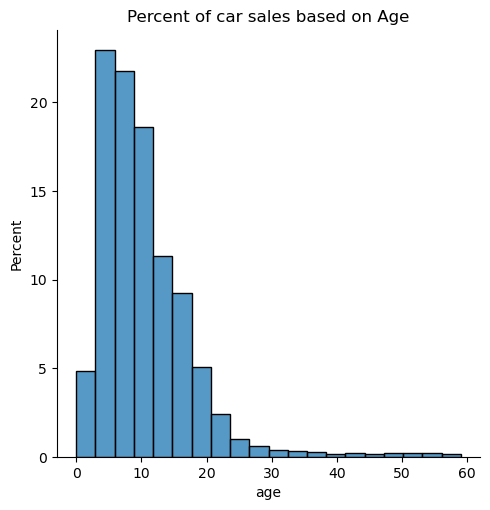

In [248]:
sns.displot(car_clean[car_clean['age']<60], x='age', stat='percent', bins = 20)
plt.title('Percent of car sales based on Age')

<function matplotlib.pyplot.show(close=None, block=None)>

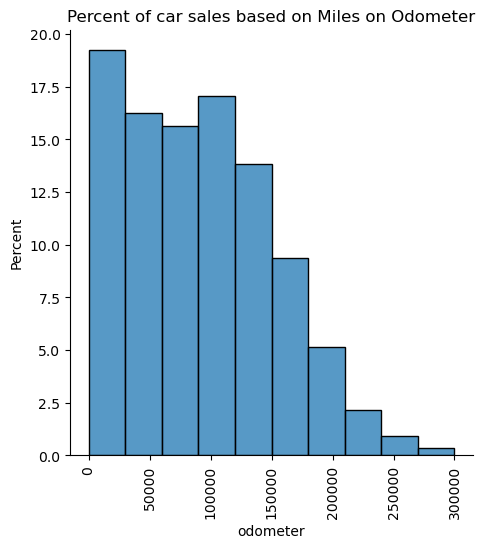

In [249]:
ax = sns.displot(car_clean[car_clean['odometer']<300000], x='odometer', stat='percent', bins = 10)
plt.title('Percent of car sales based on Miles on Odometer')
plt.xticks(rotation=90)
plt.show

Text(0.5, 1.0, 'Percent of car sales based on Number of Cylinders')

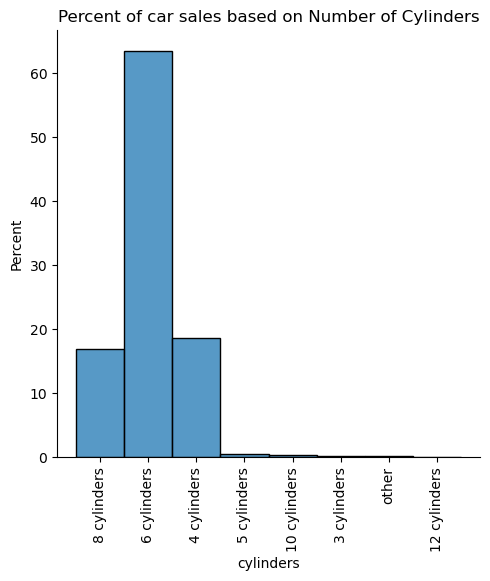

In [250]:
sns.displot(car_clean, x='cylinders', stat='percent', bins = 10)
plt.xticks(rotation=90)
plt.title('Percent of car sales based on Number of Cylinders')

### Evaluation

Out of all the models run, LinearRegression performed equally well with Ridge and Lasso, using hyperparameter tuning. As such, for this problem, using LinearRegression seems to be an appropriate choice.

Using 9 variables for LinearRegression provided the lowest Training MSE, however, it is likely to slighly overfit the data given LinearRegression with 6 variables has a lower Test MSE.

Comparing 3 vs. 6 variables, there is a marginal improvement in the model accuracy.

In summary, looking at the LinearRegression results, the primary variables that define a car's price are as follows:
- age (most relevant) -> lower the age, higher the price
- cylinders -> higher the cylinders, higher the price
- odometer (least relevant) -> lower the odometer, higher the price

The secondary variables that define a car's price are as follows:
- transmission (most relevant). price automatic > manual
- fuel -> price of diesel > gas
- drive (least relevant) -> price of 4wd > rwd > fwd

Looking at volumes of sales primary drivers (age, cylinders, odometer), most of the car sales volumes are aligned well with the variables driving the price. As such, dealers going after those drivers should have plenty of supply.


### Next Steps

LinearRegression seem to perform well for the problem. Due to limited time, we have not spent much effort to explore different transformations of data. Some of the additional transformations that can be tried can be:
- Instead of random order of Ordinal encoding of certain variables (ex: manufacturer), we can use OneHot encoding. For manufacturer, this should help capturing brands that sell for more than others (ex: luxury brands)
- We can also try polinomials with various degrees to capture non-linear aspects of the data
- With many variables coming from OneHot encoding and polynomials, variable reduction techniques could be analyzed, such as doing a grid search on various alphas with Ridge/Lasso regression or squential future selection.

Those enhancements should increase model performance.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.